In [1]:
# Determine if this is a benchmarking run
try:
    __benchmark__
except NameError:
    __benchmark__ = False

# Basics: Surface maps
Here we'll discuss how to instantiate surface maps, plot them, rotate them, and compute phase curves and occultation light curves.

## Importing `starry`

In [2]:
import starry

... and some other stuff, too.

In [3]:
import numpy as np
import matplotlib.pyplot as pl

In [4]:
%matplotlib inline

## Creating a `starry` map
A map is a vector of spherical harmonic coefficients, indexed by increasing order and degree:

$y = \{Y_{0,0}, \, Y_{1,-1}, \, Y_{1,0}, \, Y_{1,1} \, Y_{2,-2}, \, Y_{2,-1}, \, Y_{2,0} \, Y_{2,1}, \, Y_{2,2}, \, ...\}$

We create one by instantiating a `starry.Map` object. The `starry.Map` object takes a single argument, `lmax`, which is the highest order of the spherical harmonics used to describe the map. Let's keep things simple for now and create a 1st-order map:

In [5]:
map = starry.Map(1)

Our map is currently a null map: 

In [6]:
print(map)

<STARRY Map: Null>


We can edit the map directly by specifying the spherical harmonics we wish to add. Say we want our map to be very simple and equal to the spherical harmonic $Y_{1,-1}$:

In [7]:
map[1, -1] = 1
print(map)

<STARRY Map: Y_{1,-1}>


## Visualizing the map

Easy:

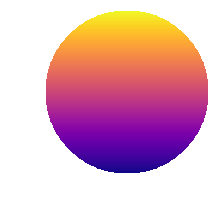

In [8]:
map.show()

As you can verify on [Wikipedia](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics), the spherical harmonic $Y_{1,-1}$ in Cartesian coordinates is simply some constant times $y$, which is what we are seeing here: a uniform gradient from negative flux at the south pole to positive flux at the north pole of the body.

## Applying rotations
One thing that `starry` allows us to do easily is rotate the base map. As an example, let's rotate the map 90 degrees about the *z*-axis:

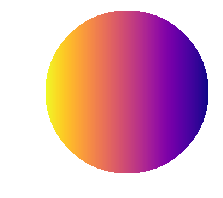

In [9]:
map.rotate(axis=[0, 0, 1], theta=90)
map.show()

As you can probably guess, the `axis` argument is a unit vector corresponding to the axis of rotation, which in this example we set to the *z* axis. The `theta` argument is the angle of rotation in radians, measured counter-clockwise as we stare down the axis of rotation. If we print the `Map` instance, we notice that the base map has changed:

In [10]:
print(map)

<STARRY Map: -Y_{1,1}>


In [11]:
if __benchmark__:
    assert np.allclose(map.y, np.array([0., 0., 0., -1.]))

One of the many cool things about spherical harmonics is that rotation of a $Y_{lm}$ in 3D space about any axis results in a linear combination of $Y_{lm'}$s of the same order $l$. In this case, the rotation transformed the map to  (negative) $Y_{1,1}$, which is just [proportional](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics) to (negative) $x$.

Let's apply another 90-degree rotation to the map, this time about the $y$-axis:

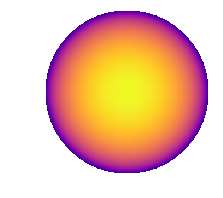

In [12]:
map.rotate(axis=[0, 1, 0], theta=90)
map.show()

In [13]:
print(map)

<STARRY Map: Y_{1,0}>


In [14]:
if __benchmark__:
    assert np.allclose(map.y, np.array([0., 0., 1., 0.]))

Our map is now the spherical harmonic $Y_{1,0}$, which is [proportional](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics) to $z$. Finally, let's apply one final rotation about the $x$ axis to return our map to the original orientation:

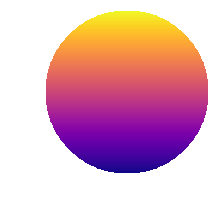

In [15]:
map.rotate(axis=[1, 0, 0], theta=-90)
map.show()

In [16]:
print(map)

<STARRY Map: Y_{1,-1}>


In [17]:
if __benchmark__:
    assert np.allclose(map.y, np.array([0., 1., 0., 0.]))

## Computing phase curves
What we really would like to do is compute light curves. So let's get to it. Everything you need is in the `flux` method:

```
def flux(self, axis=[0, 1, 0], theta=0, xo=0, yo=0, ro=0):
    ...
```

As before, the `axis` and `theta` parameters define the orientation of the map. The parameters `xo`, `yo`, and `ro` define the location and size of the occulting body (if any) relative to the `Map` object. `xo` and `yo` are the location of the center of the occultor and `ro` is its radius, all measured in units of the `Map` object's radius (=1). By the way, `theta`, `xo`, `yo`, and `ro` can all be either scalars or vectors. If more than one is a vector, their sizes must (obviously) match.

To start, let's simply compute some phase curves, with no occultations. We will vary `theta` between 0 and 360 degrees. Let's create two `theta` grids: a fine one, for the analytic calculations, and a coarse one, for the numerical calculations, so we can compare the results.

In [18]:
theta = np.linspace(0, 360, 100, endpoint=False)
theta_num = np.linspace(0, 360, 20, endpoint=False)

Let's rotate our map about the $x$-axis:

In [19]:
F = map.flux(axis=[1, 0, 0], theta=theta)

Let's do the same calculation numerically:

In [20]:
F_num = map._flux_numerical(axis=[1, 0, 0], theta=theta_num)

Compare the results:

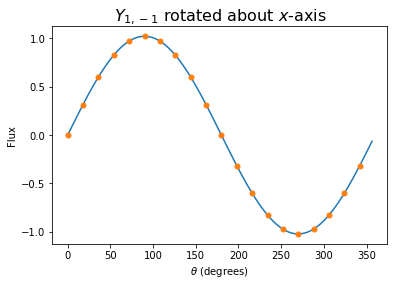

In [21]:
fig, ax = pl.subplots(1)
ax.plot(theta, F);
ax.plot(theta_num, F_num, '.', ms=10);
ax.set_xlabel(r'$\theta$ (degrees)');
ax.set_ylabel(r'Flux');
ax.set_title(r'$' + str(map)[13:-1] + r'$ rotated about $x$-axis', fontsize=16);

In [22]:
if __benchmark__:
    assert np.all(np.abs(F[::5] - F_num) < 0.01)

Rotation of $Y_{-1,1}$ about either the $y$ axis or the $z$ axis results in no phase variation because of its symmetry. So let's look at a higher order spherical harmonic just for fun:

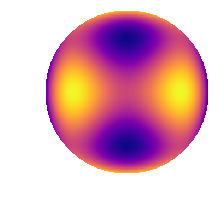

<STARRY Map: Y_{4,2}>


In [23]:
map = starry.Map(4)
map[4, 2] = 1
map.show()
print(map)

Let's rotate it about all three principal axes and look at its phase curves.

In [24]:
Fx = map.flux(axis=[1, 0, 0], theta=theta)
Fy = map.flux(axis=[0, 1, 0], theta=theta)
Fz = map.flux(axis=[0, 0, 1], theta=theta)

In [25]:
Fx_num = map._flux_numerical(axis=[1, 0, 0], theta=theta_num)
Fy_num = map._flux_numerical(axis=[0, 1, 0], theta=theta_num)
Fz_num = map._flux_numerical(axis=[0, 0, 1], theta=theta_num)

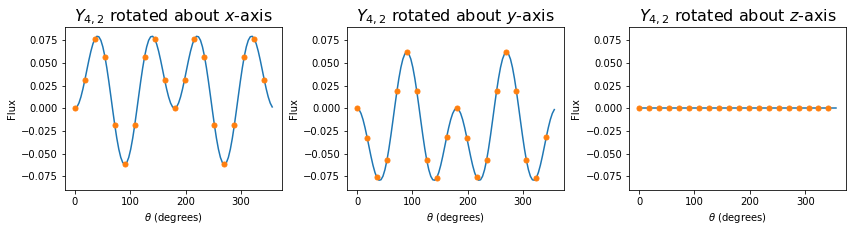

In [26]:
fig, ax = pl.subplots(1,3, figsize=(14,3))
fig.subplots_adjust(wspace=0.3)
axis = ['x', 'y', 'z']
for i, F, F_num in zip(range(3), [Fx, Fy, Fz], [Fx_num, Fy_num, Fz_num]):
    ax[i].plot(theta, F);
    ax[i].plot(theta_num, F_num, '.', ms=10);
    ax[i].set_xlabel(r'$\theta$ (degrees)');
    ax[i].set_ylabel(r'Flux');
    ax[i].set_title(r'$' + str(map)[13:-1] + r'$ rotated about $%s$-axis' % axis[i], fontsize=16);
    ax[i].set_ylim(-0.09,0.09)

In [27]:
if __benchmark__:
    assert np.all(np.abs(Fx[::5] - Fx_num) < 0.01)
    assert np.all(np.abs(Fy[::5] - Fy_num) < 0.01)
    assert np.all(np.abs(Fz[::5] - Fz_num) < 0.01)

## Computing occultation light curves
These are just as easy!

Let's start with the following map:

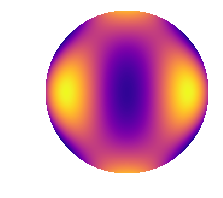

<STARRY Map: 2 Y_{0,0} - 0.50 Y_{4,0} + 0.50 Y_{4,2} + 0.50 Y_{4,4}>


In [28]:
map = starry.Map(4)
map[0, 0] = 2
map[4, 0] = -0.5
map[4, 2] = 0.5
map[4, 4] = 0.5
map.show()
print(map)

Consider an occultor of radius 0.1 moving along the $+x$ direction at $y_0 = 0.5$. Suppose that the occulted body rotates by an angle $\pi/8$ about the $y$-axis in the meantime. Computing the light curve is easy:

In [29]:
npts = 100
ro = 0.1
xo = np.linspace(-3,3, npts)
yo = 0.5
axis = [0, 1, 0]
theta = np.linspace(0, 45, npts, endpoint=False)
F = map.flux(axis=axis, theta=theta, xo=xo, yo=yo, ro=ro)

As before, let's compute the flux numerically as a check. I'm decreasing the tolerance significantly so we can get a good numerical estimate. This should take <10 seconds to run:

In [30]:
theta_num = np.linspace(0, 45, 50, endpoint=False)
xo_num = np.linspace(-3, 3, 50)
F_num = map._flux_numerical(axis=axis, theta=theta_num, xo=xo_num, yo=yo, ro=ro, tol=1e-6)

Here's the rather odd-looking light curve:

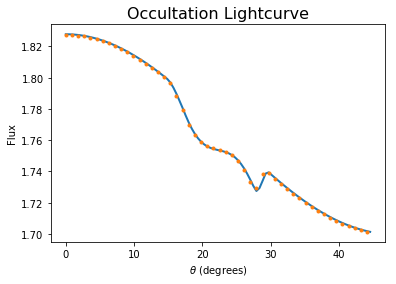

In [31]:
fig, ax = pl.subplots(1)
ax.plot(theta, F, lw=2);
ax.plot(theta_num, F_num, '.', ms=6);
ax.set_xlabel(r'$\theta$ (degrees)');
ax.set_ylabel(r'Flux');
ax.set_title(r'Occultation Lightcurve', fontsize=16);

In [32]:
if __benchmark__:
    assert np.all(np.abs(F[::2] - F_num) < 0.01)